# Flatiron Health mPC: Relaxed trials with GBM crude

***OBJECTIVE:*** **Reproduce 4 landmark clinical trials in metastatic colorectal cancer. Inclusion criteria for these trials will be pragmatically relaxed to allow for entry of our real-world patients, many of which would not meet inclusion criteria in randomized controlled trials. Patients included in our trials will next be risk stratified using the gradient boosted model with crude imputation into 1 of 3 risk groups: high (top tertile), medium (middle tertile), and low (bottom tertile). Inverse-probability treatment weighted survival analysis will then be performed across these risk groups to get real-world estimates of survival while adjusting for measured confounders.** 

***OUTLINE:***
1. **Preprocessing**


2. **In-silico trials:**
* CHAARTED
* LATITUDE 

## Part 1: Preprocessing

### 1.1 Import packages and create necessary functions

In [1]:
import numpy as np
import pandas as pd

from scipy import stats

from sksurv.nonparametric import kaplan_meier_estimator
from survive import KaplanMeier, SurvivalData

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import median_survival_times

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LogisticRegression

from matplotlib.lines import Line2D   

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

In [3]:
# Find index for value closest to input value. 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [4]:
# Calculates probability of survival at time t-months for risk groups. 
def psurv_t(low, med, high, t):
    low_t = low.survival_function_at_times(find_nearest(low.timeline, t)).values[0]*100
    med_t = med.survival_function_at_times(find_nearest(med.timeline, t)).values[0]*100
    high_t = high.survival_function_at_times(find_nearest(high.timeline, t)).values[0]*100
    pos_t = [low_t, med_t, high_t]
    return (pos_t)

In [5]:
# Calculates median overeall suvival for risk groups. 
def mos(low, med, high, comp):
    low_os = low.median_survival_time_
    med_os = med.median_survival_time_
    high_os = high.median_survival_time_
    comp_os = comp.median_survival_time_
    mos = [low_os, med_os, high_os, comp_os]
    return (mos)

In [6]:
# Calculates upper and lower 95% CI for median overall survival. 
def mos_ci(kmf):
    kmf_mos_low = (
        kmf.confidence_interval_[['KM_estimate_lower_0.95']]
        [kmf.confidence_interval_[['KM_estimate_lower_0.95']] == find_nearest(kmf.confidence_interval_['KM_estimate_lower_0.95'], 0.5)]
        .idxmin()[0])

    kmf_mos_up = (
        kmf.confidence_interval_[['KM_estimate_upper_0.95']]
        [kmf.confidence_interval_[['KM_estimate_upper_0.95']] == find_nearest(kmf.confidence_interval_['KM_estimate_upper_0.95'], 0.5)]
        .idxmin()[0])
    
    mos_ci = [kmf_mos_low, kmf_mos_up]
    return (mos_ci)

In [7]:
# Calculates upper and lower 95% CI for probability of survival at time t. 
def psurv_ci(kmf, t):
    kmf_psurv_ci_low = (
        kmf.confidence_interval_.loc[find_nearest(kmf.confidence_interval_.index, t)][0]*100)

    kmf_psurv_ci_up = (
        kmf.confidence_interval_.loc[find_nearest(kmf.confidence_interval_.index, t)][1]*100)
    
    psurv_ci = [kmf_psurv_ci_low, kmf_psurv_ci_up]
    return (psurv_ci)

In [8]:
# Calculate median overall survival or psurv error. 
def y_error(low_ci, med_ci, high_ci, surv_metric):
    error = [np.array([surv_metric[0] - low_ci[0],
                       surv_metric[1]- med_ci[0],
                       surv_metric[2] - high_ci[0]]),
               np.array([low_ci[1] - surv_metric[0],
                         med_ci[1] - surv_metric[1],
                         high_ci[1] - surv_metric[2]])]
    return(error)

In [9]:
# Cutoff decimlas to length n. 
def truncate(n, decimals = 0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

### 1.2 Process data 

In [10]:
train = pd.read_csv('train_full.csv')
row_ID(train)

(15141, 15141)

In [11]:
test = pd.read_csv('test_full.csv')
row_ID(test)

(3786, 3786)

In [12]:
df = pd.concat([train, test], ignore_index = True)
row_ID(df)

(18927, 18927)

In [13]:
#crude_risk_score_df = pd.read_csv('crude_risk_score_df.csv')

In [14]:
#df = pd.merge(df, crude_risk_score_df, on = 'PatientID')

In [15]:
#df.to_csv('df_risk_crude.csv', index = False, header = True)

## Part 2: In silico trials 

### CHAARTED: docetaxel vs. ADT in metastatic, castration-sensitive prostate cancer  

**INCLUSION**
* Untreated metastatic prostate cancer, except up to 4 months of ADT 
* Castration-sensitive
* Received ADT or docetaxel plus ADT

#### ADT

In [16]:
df_full = pd.read_csv('df_risk_crude.csv', dtype = {'death_status': bool})
df_full.index.nunique()

18927

In [17]:
adt = pd.read_csv('Enhanced_MetPC_ADT.csv')

In [18]:
adt = (
    adt[adt['PatientID'].isin(df_full['PatientID'])]
    .query('TreatmentSetting == "Advanced"')
)

In [19]:
row_ID(adt)

(17863, 17863)

In [20]:
adt.loc[:, 'StartDate'] = pd.to_datetime(adt['StartDate'])

In [21]:
adt = adt.rename(columns = {'StartDate': 'StartDate_adt'})

In [22]:
df_full = pd.merge(df_full, adt[['PatientID', 'StartDate_adt']], on = 'PatientID', how = 'outer')

In [23]:
row_ID(df_full)

(18927, 18927)

In [24]:
enhanced_met = pd.read_csv('Enhanced_MetProstate.csv')

In [25]:
enhanced_met = enhanced_met[enhanced_met['PatientID'].isin(df_full['PatientID'])]

In [26]:
enhanced_met.loc[:, 'MetDiagnosisDate'] = pd.to_datetime(enhanced_met['MetDiagnosisDate'])

In [27]:
enhanced_met.loc[:, 'CRPCDate'] = pd.to_datetime(enhanced_met['CRPCDate'])

In [28]:
df_full = pd.merge(df_full, enhanced_met[['PatientID', 'MetDiagnosisDate', 'CRPCDate']], on = 'PatientID')

In [29]:
row_ID(df_full)

(18927, 18927)

In [30]:
# Find all that start ADT within -120 to +90 days of metastatic diagnosis 
chaarted_adt = (
    df_full
    .assign(adt_diff = (df_full['StartDate_adt'] - df_full['MetDiagnosisDate']).dt.days)
    .query('adt_diff >= -120 and adt_diff <= 90')
)

In [31]:
# Find all that have missing CPRC date or date is >90 after metastatic diagnosis 
chaarted_adt = (
    chaarted_adt
    .assign(crpc_diff = (chaarted_adt['CRPCDate'] - chaarted_adt['MetDiagnosisDate']).dt.days)
    .query('crpc_diff > 90 or CRPCDate.isna()', engine = 'python')
)

In [32]:
row_ID(chaarted_adt)

(10475, 10475)

In [33]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [34]:
zero = (
    line_therapy.query('LineNumber == 0')
    .PatientID
)

In [35]:
# Exclude patients with missing treatment information (ie, LineNumber == 0)
chaarted_adt = chaarted_adt[~chaarted_adt.PatientID.isin(zero)]

In [36]:
row_ID(chaarted_adt)

(10117, 10117)

In [37]:
line_therapy = line_therapy.query('LineSetting != "nmCRPC"')

In [38]:
# List of FDA approved drugs for mPC as of July 2023. Clinical study drug is also included. 
fda_yes = [
    'Abiraterone',
    'Apalutamide',
    'Cabazitaxel',
    'Carboplatin',
    'Cisplatin',
    'Darolutamide',
    'Docetaxel',
    'Enzalutamide',
    'Mitoxantrone',
    'Olaparib',
    'Oxaliplatin',
    'Paclitaxel',
    'Pembrolizumab',
    'Radium-223',
    'Rucaparib',
    'Sipuleucel-T',
    'Clinical Study Drug'
]

In [39]:
line_therapy = line_therapy[line_therapy['LineName'].str.contains('|'.join(fda_yes))]

In [40]:
line_therapy = (
    line_therapy
    .sort_values(by = ['PatientID', 'StartDate'], ascending = [True, True])
)

In [41]:
line_therapy['line_number'] = (
    line_therapy.groupby('PatientID')['LineNumber'].cumcount()+1
)

In [42]:
# First line therapy is in castrate-resistant setting 
fl_crpc = (
    line_therapy[line_therapy.PatientID.isin(chaarted_adt.PatientID)]
    .query('line_number == 1 & LineSetting == "mCRPC"')
    .PatientID
)

In [43]:
# Never received therapy other than ADT
notrt_adt = (
    chaarted_adt[~chaarted_adt.PatientID.isin(line_therapy.PatientID)]
    .PatientID
)

In [44]:
adt_IDs = np.concatenate((fl_crpc, notrt_adt))

In [45]:
len(adt_IDs)

6218

In [46]:
chaarted_adt = chaarted_adt[chaarted_adt.PatientID.isin(adt_IDs)]

In [47]:
chaarted_adt.loc[:,'adt_dotx'] = 0

In [48]:
row_ID(chaarted_adt)

(6218, 6218)

In [49]:
chaarted_adt.sample(3)

,PatientID,Gender,race,ethnicity,age,p_type,NStage,MStage,Histology,GleasonScore,...,other_met,prim_treatment,early_adt,risk_score,StartDate_adt,MetDiagnosisDate,CRPCDate,adt_diff,crpc_diff,adt_dotx
581,F397E22BF8702,M,white,unknown,66,COMMUNITY,N1,M1,Adenocarcinoma,9,...,0.0,unknown,0.0,-0.477476,2018-12-01,2018-11-21,NaT,10.0,NaN,0
6698,FF9701ADF6C2C,M,other,unknown,58,COMMUNITY,Unknown / Not documented,Unknown / Not documented,"Prostate cancer, NOS",Unknown / Not documented,...,0.0,prostatectomy,0.0,-0.684579,2014-04-15,2014-04-09,2016-03-15,6.0,706.0,0
16266,F6AB9B3845D6A,M,white,unknown,66,ACADEMIC,Unknown / Not documented,M0,Adenocarcinoma,9,...,0.0,prostatectomy,0.0,-0.957030,2015-10-15,2015-09-18,NaT,27.0,NaN,0


#### Docetaxel + ADT

In [50]:
# Find those that start ADT within -90 to 90 days of metastaic diagnosis 
chaarted_dotx = (
    df_full
    .assign(adt_diff = (df_full['StartDate_adt'] - df_full['MetDiagnosisDate']).dt.days)
    .query('adt_diff >= -120 and adt_diff <= 90')
)

In [51]:
# Find all that have missing CPRC date or date is >90 days metastatic diagnosis 
chaarted_dotx = (
    chaarted_dotx
    .assign(crpc_diff = (chaarted_dotx['CRPCDate'] - chaarted_dotx['MetDiagnosisDate']).dt.days)
    .query('crpc_diff > 90 or CRPCDate.isna()', engine = 'python')
)

In [52]:
row_ID(chaarted_dotx)

(10475, 10475)

In [53]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [54]:
# Find start time of first line of mHSPC therapy. 
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(chaarted_dotx['PatientID'])]
    .query('LineSetting == "mHSPC"')
    .sort_values(by = ['PatientID', 'StartDate'], ascending = [True, True])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .rename(columns = {'StartDate': 'StartDate_dotx'})
)

In [55]:
row_ID(line_therapy_fl)

(4042, 4042)

In [56]:
line_therapy_fl.loc[:, 'StartDate_dotx'] = pd.to_datetime(line_therapy_fl['StartDate_dotx'])

In [57]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('Docetaxel')].LineName.value_counts().head(10)

Docetaxel                                         1363
Abiraterone,Docetaxel                               27
Carboplatin,Docetaxel                               12
Clinical Study Drug,Docetaxel                       11
Darolutamide,Docetaxel                               9
Docetaxel,Enzalutamide                               6
Carboplatin,Docetaxel,Estramustine                   5
Docetaxel,Ketoconazole                               3
Apalutamide,Docetaxel                                2
Carboplatin,Docetaxel,Estramustine,Thalidomide       2
Name: LineName, dtype: int64

In [58]:
line_dotx = line_therapy_fl.query('LineName == "Docetaxel"')

In [59]:
row_ID(line_dotx)

(1363, 1363)

In [60]:
chaarted_dotx = pd.merge(chaarted_dotx, line_dotx[['PatientID', 'StartDate_dotx']], on = 'PatientID', how = 'inner')

In [61]:
row_ID(chaarted_dotx)

(1363, 1363)

In [62]:
# Find all patients that start enzalutamide within 180 days of metastatic diagnosis
chaarted_dotx = (
    chaarted_dotx
    .assign(fl_diff = (chaarted_dotx['StartDate_dotx'] - chaarted_dotx['StartDate_adt']).dt.days)
    .query('fl_diff >= -90 and fl_diff <= 90')
)

In [63]:
len(chaarted_dotx)

1179

In [64]:
chaarted_dotx.sample(3)

,PatientID,Gender,race,ethnicity,age,p_type,NStage,MStage,Histology,GleasonScore,...,prim_treatment,early_adt,risk_score,StartDate_adt,MetDiagnosisDate,CRPCDate,adt_diff,crpc_diff,StartDate_dotx,fl_diff
715,F5A4FB077B40E,M,white,unknown,74,COMMUNITY,N1,M1b,"Prostate cancer, NOS",9,...,unknown,0.0,-0.296410,2016-04-29,2016-04-14,2018-01-16,15.0,642.0,2016-05-20,21
108,FFE926BB3F77E,M,white,unknown,49,COMMUNITY,Unknown / Not documented,M1,Adenocarcinoma,9,...,unknown,0.0,1.183903,2016-10-07,2016-09-27,2017-06-16,10.0,262.0,2016-11-01,25
986,FEB5DBB0284E1,M,white,unknown,68,BOTH,Unknown / Not documented,M1,Adenocarcinoma,8,...,unknown,0.0,-1.113043,2017-10-24,2017-09-19,NaT,35.0,NaN,2017-12-04,41


In [65]:
chaarted_dotx.loc[:,'adt_dotx'] = 1

In [66]:
chaarted = pd.concat([chaarted_adt, chaarted_dotx], ignore_index = True)

In [67]:
row_ID(chaarted)

(7397, 7397)

In [68]:
chaarted.adt_dotx.value_counts(dropna = False)

0    6218
1    1179
Name: adt_dotx, dtype: int64

In [69]:
chaarted.sample(3)

,PatientID,Gender,race,ethnicity,age,p_type,NStage,MStage,Histology,GleasonScore,...,early_adt,risk_score,StartDate_adt,MetDiagnosisDate,CRPCDate,adt_diff,crpc_diff,adt_dotx,StartDate_dotx,fl_diff
5180,FD021A08D3227,M,black,unknown,73,COMMUNITY,Unknown / Not documented,M1,Adenocarcinoma,9,...,0.0,-0.335617,2016-02-01,2016-01-21,2018-08-14,11.0,936.0,0,NaT,NaN
5244,F38EA51E2ED45,M,unknown,unknown,74,COMMUNITY,Unknown / Not documented,Unknown / Not documented,Adenocarcinoma,Less than or equal to 6,...,1.0,-0.504773,2016-01-01,2016-04-07,2020-08-25,-97.0,1601.0,0,NaT,NaN
6272,F8EDE0BEBC892,M,white,unknown,66,COMMUNITY,Unknown / Not documented,M1,Adenocarcinoma,Unknown / Not documented,...,0.0,-0.559730,2019-10-18,2019-10-18,NaT,0.0,NaN,1,2019-12-02,45.0


#### Time from ADT treatment to death or censor 

In [70]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [71]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [72]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [73]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [74]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
row_ID(mortality)

(18927, 18927)

In [75]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [76]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [77]:
len(mortality)

18927

In [78]:
chaarted = pd.merge(chaarted, mortality, on = 'PatientID')

In [79]:
row_ID(chaarted)

(7397, 7397)

In [80]:
conditions = [
    (chaarted['death_status'] == 1),
    (chaarted['death_status'] == 0)]

choices = [
    (chaarted['death_date'] - chaarted['StartDate_adt']).dt.days,
    (chaarted['last_activity'] - chaarted['StartDate_adt']).dt.days]

chaarted.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

chaarted = chaarted.query('timerisk_treatment >= 0')

#### Patient count 

In [81]:
low_cutoff_chaarted = chaarted.risk_score.quantile(1/3)

In [82]:
high_cutoff_chaarted = chaarted.risk_score.quantile(2/3)

In [83]:
print('Docetaxel + ADT:',  chaarted.query('adt_dotx == 1').shape[0])
print('High risk:', chaarted.query('adt_dotx == 1').query('risk_score >= @high_cutoff_chaarted').shape[0])
print('Med risk:', chaarted.query('adt_dotx == 1').query('risk_score < @high_cutoff_chaarted and risk_score > @low_cutoff_chaarted').shape[0])
print('Low risk:', chaarted.query('adt_dotx == 1').query('risk_score <= @low_cutoff_chaarted').shape[0])

Docetaxel + ADT: 1179
High risk: 316
Med risk: 424
Low risk: 439


In [84]:
print('ADT:',  chaarted.query('adt_dotx == 0').shape[0])
print('High risk:', chaarted.query('adt_dotx == 0').query('risk_score >= @high_cutoff_chaarted').shape[0])
print('Med risk:', chaarted.query('adt_dotx == 0').query('risk_score < @high_cutoff_chaarted and risk_score > @low_cutoff_chaarted').shape[0])
print('Low risk:', chaarted.query('adt_dotx == 0').query('risk_score <= @low_cutoff_chaarted').shape[0])

ADT: 6218
High risk: 2150
Med risk: 2041
Low risk: 2027


In [85]:
data = {'low': [low_cutoff_chaarted],
        'high': [high_cutoff_chaarted]}

risk_cutoff_prostate = pd.DataFrame(data = data, index = ['chaarted'])

#### OS curves without confounder adjustment 

In [86]:
chaarted = chaarted.set_index('PatientID')

In [87]:
chaarted_low_dotx = (
    chaarted
    .query('adt_dotx == 1')
    .query('risk_score <= @low_cutoff_chaarted')
    .index)

chaarted_low_adt = (
    chaarted
    .query('adt_dotx == 0')
    .query('risk_score <= @low_cutoff_chaarted')
    .index)

chaarted_med_dotx = (
    chaarted
    .query('adt_dotx == 1')
    .query('risk_score < @high_cutoff_chaarted and risk_score > @low_cutoff_chaarted')
    .index)

chaarted_med_adt = (
    chaarted
    .query('adt_dotx == 0')
    .query('risk_score < @high_cutoff_chaarted and risk_score > @low_cutoff_chaarted')
    .index)

chaarted_high_dotx = (
    chaarted
    .query('adt_dotx == 1')
    .query('risk_score >= @high_cutoff_chaarted')
    .index)

chaarted_high_adt = (
    chaarted
    .query('adt_dotx == 0')
    .query('risk_score >= @high_cutoff_chaarted')
    .index)

chaarted_all_dotx = (
    chaarted
    .query('adt_dotx == 1')
    .index)

chaarted_all_adt = (
    chaarted
    .query('adt_dotx == 0')
    .index)

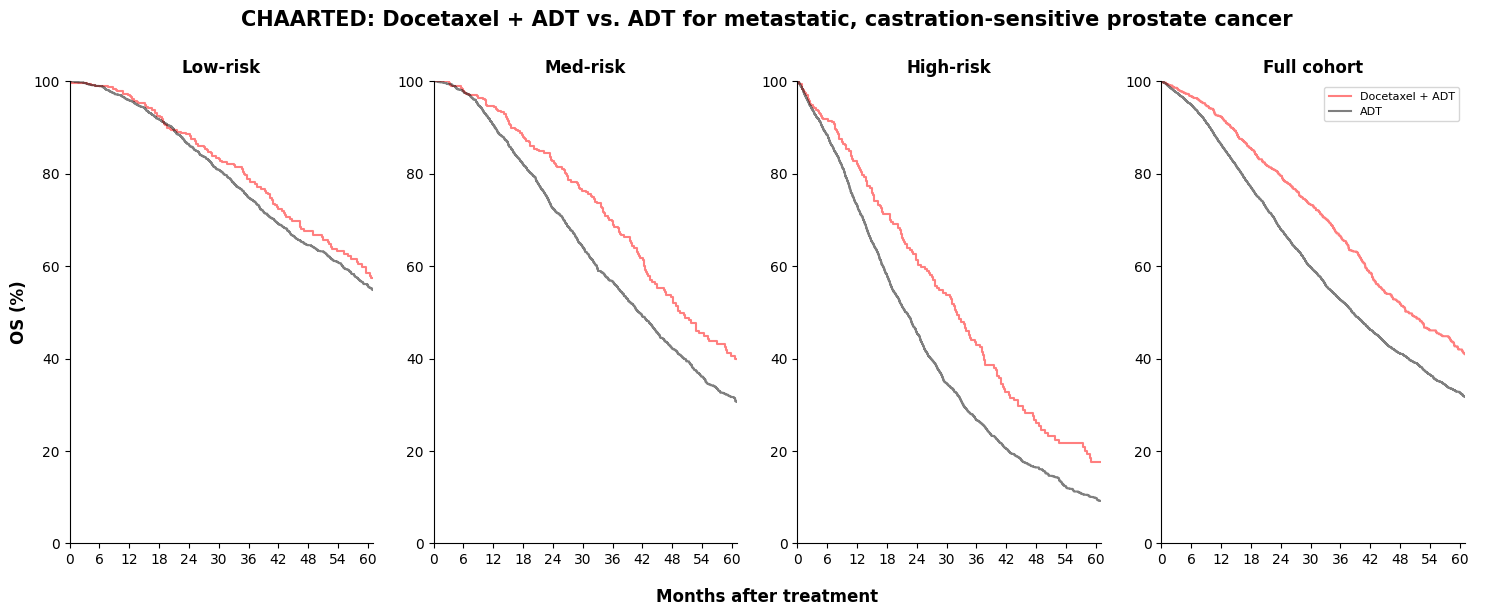

In [88]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

time_low_dotx, survival_prob_low_dotx = kaplan_meier_estimator(np.array(chaarted.loc[chaarted_low_dotx]['death_status']),
                                                               np.array(chaarted.loc[chaarted_low_dotx]['timerisk_treatment']))

time_low_adt_c, survival_prob_low_adt_c = kaplan_meier_estimator(np.array(chaarted.loc[chaarted_low_adt]['death_status']),
                                                                 np.array(chaarted.loc[chaarted_low_adt]['timerisk_treatment']))

plt.step(time_low_dotx/30, survival_prob_low_dotx*100, color = 'red', alpha = 0.5)
plt.step(time_low_adt_c/30, survival_prob_low_adt_c*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('OS (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for medium risk group. 
plt.subplot(1, 4, 2)

time_med_dotx, survival_prob_med_dotx = kaplan_meier_estimator(np.array(chaarted.loc[chaarted_med_dotx]['death_status']),
                                                               np.array(chaarted.loc[chaarted_med_dotx]['timerisk_treatment']))

time_med_adt_c, survival_prob_med_adt_c = kaplan_meier_estimator(np.array(chaarted.loc[chaarted_med_adt]['death_status']),
                                                                 np.array(chaarted.loc[chaarted_med_adt]['timerisk_treatment']))

plt.step(time_med_dotx/30, survival_prob_med_dotx*100, color = 'red', alpha = 0.5)
plt.step(time_med_adt_c/30, survival_prob_med_adt_c*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

time_high_dotx, survival_prob_high_dotx = kaplan_meier_estimator(np.array(chaarted.loc[chaarted_high_dotx]['death_status']),
                                                                 np.array(chaarted.loc[chaarted_high_dotx]['timerisk_treatment']))

time_high_adt_c, survival_prob_high_adt_c = kaplan_meier_estimator(np.array(chaarted.loc[chaarted_high_adt]['death_status']),
                                                                   np.array(chaarted.loc[chaarted_high_adt]['timerisk_treatment']))

plt.step(time_high_dotx/30, survival_prob_high_dotx*100, color = 'red', alpha = 0.5)
plt.step(time_high_adt_c/30, survival_prob_high_adt_c*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatmetn for all 
plt.subplot(1, 4, 4)

time_all_dotx, survival_prob_all_dotx = kaplan_meier_estimator(np.array(chaarted.loc[chaarted_all_dotx]['death_status']),
                                                               np.array(chaarted.loc[chaarted_all_dotx]['timerisk_treatment']))

time_all_adt_c, survival_prob_all_adt_c = kaplan_meier_estimator(np.array(chaarted.loc[chaarted_all_adt]['death_status']),
                                                                 np.array(chaarted.loc[chaarted_all_adt]['timerisk_treatment']))

plt.step(time_all_dotx/30, survival_prob_all_dotx*100, color = 'red', alpha = 0.5, label = 'Docetaxel + ADT')
plt.step(time_all_adt_c/30, survival_prob_all_adt_c*100, color = 'black', alpha = 0.5, label = 'ADT')

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 8})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('CHAARTED: Docetaxel + ADT vs. ADT for metastatic, castration-sensitive prostate cancer', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Survival with confounder adjustment via IPTW

In [89]:
chaarted_iptw = chaarted.filter(items = ['death_status',
                                         'timerisk_treatment',
                                         'adt_dotx',
                                         'age',
                                         'race',
                                         'p_type',
                                         'met_year',
                                         'delta_met_diagnosis',
                                         'commercial',
                                         'medicare',
                                         'medicaid',
                                         'risk_score'])

In [90]:
chaarted_iptw.dtypes

death_status              bool
timerisk_treatment     float64
adt_dotx                 int64
age                      int64
race                    object
p_type                  object
met_year                 int64
delta_met_diagnosis      int64
commercial             float64
medicare               float64
medicaid               float64
risk_score             float64
dtype: object

In [91]:
to_be_categorical = list(chaarted_iptw.select_dtypes(include = ['object']).columns)

In [92]:
to_be_categorical

['race', 'p_type']

In [93]:
to_be_categorical.append('met_year')

In [94]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    chaarted_iptw[x] = chaarted_iptw[x].astype('category')

In [95]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_met_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [96]:
# List of categorical features.
categorical_features = list(chaarted_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [97]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [98]:
chaarted_iptw_low = (
    chaarted_iptw
    .query('risk_score <= @low_cutoff_chaarted')
    .drop(columns = ['risk_score']))

chaarted_iptw_med = (
    chaarted_iptw
    .query('risk_score < @high_cutoff_chaarted and risk_score > @low_cutoff_chaarted')
    .drop(columns = ['risk_score']))

chaarted_iptw_high = (
    chaarted_iptw
    .query('risk_score >= @high_cutoff_chaarted')
    .drop(columns = ['risk_score']))

In [99]:
chaarted_low_x = preprocessor.fit_transform(chaarted_iptw_low.filter(items = ['age',
                                                                              'race',
                                                                              'p_type',
                                                                              'delta_met_diagnosis',
                                                                              'met_year',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid']))

chaarted_med_x = preprocessor.fit_transform(chaarted_iptw_med.filter(items = ['age',
                                                                              'race',
                                                                              'p_type',
                                                                              'delta_met_diagnosis',
                                                                              'met_year',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid']))

chaarted_high_x = preprocessor.fit_transform(chaarted_iptw_high.filter(items = ['age',
                                                                              'race',
                                                                              'p_type',
                                                                              'delta_met_diagnosis',
                                                                              'met_year',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid']))

In [100]:
lr_chaarted_low = LogisticRegression(max_iter = 1000)
lr_chaarted_low.fit(chaarted_low_x, chaarted_iptw_low['adt_dotx'])

LogisticRegression(max_iter=1000)

In [101]:
lr_chaarted_med = LogisticRegression(max_iter = 1000)
lr_chaarted_med.fit(chaarted_med_x, chaarted_iptw_med['adt_dotx'])

LogisticRegression(max_iter=1000)

In [102]:
lr_chaarted_high = LogisticRegression(max_iter = 1000)
lr_chaarted_high.fit(chaarted_high_x, chaarted_iptw_high['adt_dotx'])

LogisticRegression(max_iter=1000)

In [103]:
pred_low = lr_chaarted_low.predict_proba(chaarted_low_x)
pred_med = lr_chaarted_med.predict_proba(chaarted_med_x)
pred_high = lr_chaarted_high.predict_proba(chaarted_high_x)

In [104]:
chaarted_iptw_low['ps'] = pred_low[:, 1]
chaarted_iptw_med['ps'] = pred_med[:, 1]
chaarted_iptw_high['ps'] = pred_high[:, 1]

In [105]:
chaarted_iptw_low['weight'] = (
    np.where(chaarted_iptw_low['adt_dotx'] == 1, 1/chaarted_iptw_low['ps'], 1/(1 - chaarted_iptw_low['ps'])))

chaarted_iptw_med['weight'] = (
    np.where(chaarted_iptw_med['adt_dotx'] == 1, 1/chaarted_iptw_med['ps'], 1/(1 - chaarted_iptw_med['ps'])))

chaarted_iptw_high['weight'] = (
    np.where(chaarted_iptw_high['adt_dotx'] == 1, 1/chaarted_iptw_high['ps'], 1/(1 - chaarted_iptw_high['ps'])))

In [106]:
chaarted_iptw_all = pd.concat([chaarted_iptw_low, chaarted_iptw_med, chaarted_iptw_high])

In [107]:
# Low KM curves
kmf_low_dotx_chaarted_iptw = KaplanMeierFitter()
kmf_low_adt_chaarted_iptw = KaplanMeierFitter()

kmf_low_dotx_chaarted_iptw.fit(
    chaarted_iptw_low.query('adt_dotx == 1').timerisk_treatment/30,
    chaarted_iptw_low.query('adt_dotx == 1').death_status,
    weights = chaarted_iptw_low.query('adt_dotx == 1')['weight'])

kmf_low_adt_chaarted_iptw.fit(
    chaarted_iptw_low.query('adt_dotx == 0').timerisk_treatment/30,
    chaarted_iptw_low.query('adt_dotx == 0').death_status,
    weights = chaarted_iptw_low.query('adt_dotx == 0')['weight'])

# Med KM curves
kmf_med_dotx_chaarted_iptw = KaplanMeierFitter()
kmf_med_adt_chaarted_iptw = KaplanMeierFitter()

kmf_med_dotx_chaarted_iptw.fit(
    chaarted_iptw_med.query('adt_dotx == 1').timerisk_treatment/30,
    chaarted_iptw_med.query('adt_dotx == 1').death_status,
    weights = chaarted_iptw_med.query('adt_dotx == 1')['weight'])

kmf_med_adt_chaarted_iptw.fit(
    chaarted_iptw_med.query('adt_dotx == 0').timerisk_treatment/30,
    chaarted_iptw_med.query('adt_dotx == 0').death_status,
    weights = chaarted_iptw_med.query('adt_dotx == 0')['weight'])

# High KM curves 
kmf_high_dotx_chaarted_iptw = KaplanMeierFitter()
kmf_high_adt_chaarted_iptw = KaplanMeierFitter()

kmf_high_dotx_chaarted_iptw.fit(
    chaarted_iptw_high.query('adt_dotx == 1').timerisk_treatment/30,
    chaarted_iptw_high.query('adt_dotx == 1').death_status,
    weights = chaarted_iptw_high.query('adt_dotx == 1')['weight'])

kmf_high_adt_chaarted_iptw.fit(
    chaarted_iptw_high.query('adt_dotx == 0').timerisk_treatment/30,
    chaarted_iptw_high.query('adt_dotx == 0').death_status,
    weights = chaarted_iptw_high.query('adt_dotx == 0')['weight'])

# All KM curves 
kmf_all_dotx_chaarted_iptw = KaplanMeierFitter()
kmf_all_adt_chaarted_iptw = KaplanMeierFitter()

kmf_all_dotx_chaarted_iptw.fit(
    chaarted_iptw_all.query('adt_dotx == 1').timerisk_treatment/30,
    chaarted_iptw_all.query('adt_dotx == 1').death_status,
    weights = chaarted_iptw_all.query('adt_dotx == 1')['weight'])

kmf_all_adt_chaarted_iptw.fit(
    chaarted_iptw_all.query('adt_dotx == 0').timerisk_treatment/30,
    chaarted_iptw_all.query('adt_dotx == 0').death_status,
    weights = chaarted_iptw_all.query('adt_dotx == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7416.55 total observations, 3342.29 right-censored observations>

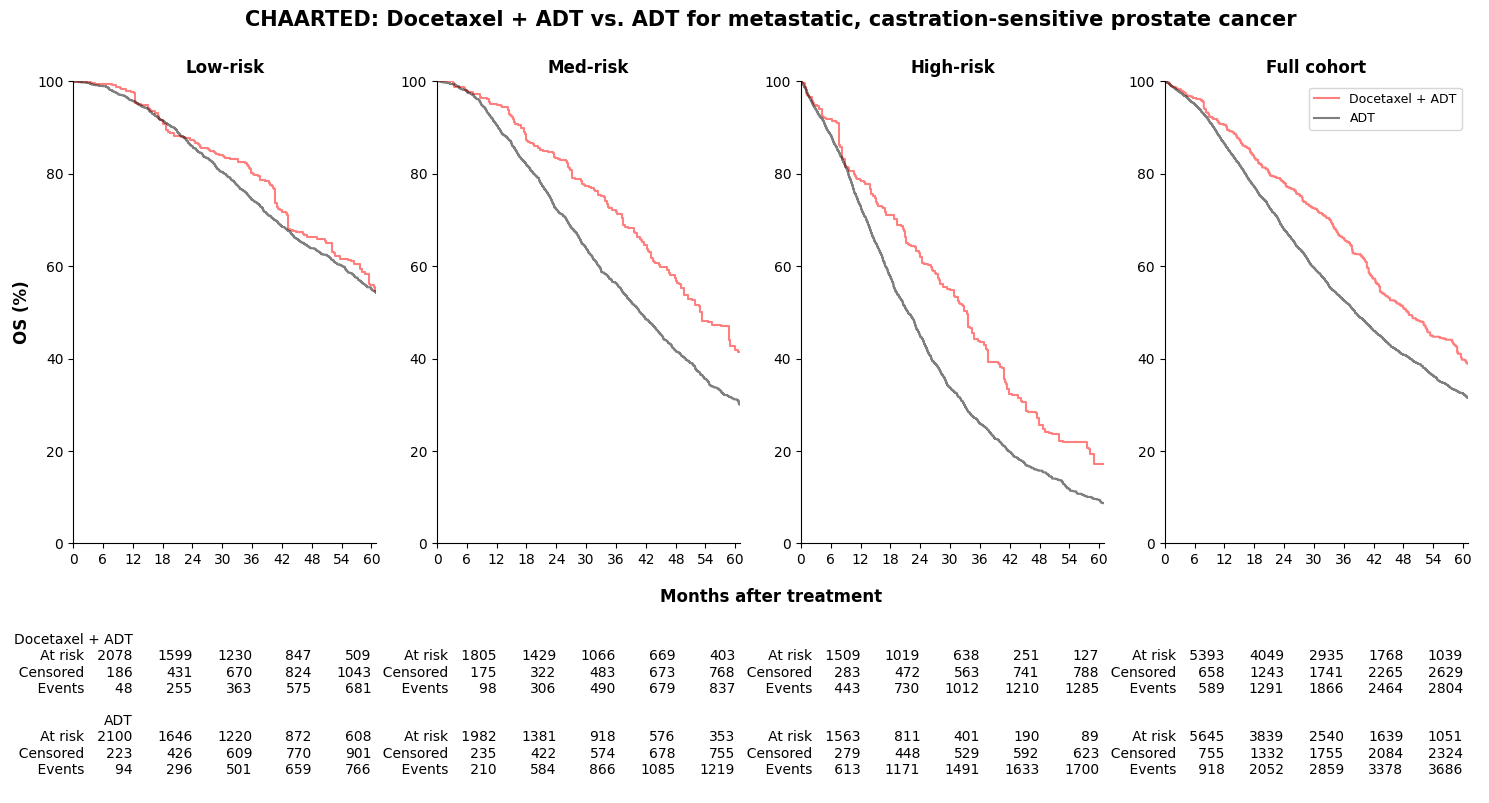

In [108]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_dotx_chaarted_iptw.timeline, kmf_low_dotx_chaarted_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_low_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_low_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_low_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_low_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_low_pfulv_paloma3_iptw.timeline, np.array(kmf_low_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_low_adt_chaarted_iptw.timeline, kmf_low_adt_chaarted_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_low_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_low_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_low_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_low_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_low_fulv_paloma3_iptw.timeline, np.array(kmf_low_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('OS (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_low_dotx_chaarted_iptw, kmf_low_adt_chaarted_iptw, ypos = -0.8, xticks = np.arange(12, 61, 12), labels = ['Docetaxel + ADT', 'ADT'])

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_dotx_chaarted_iptw.timeline, kmf_med_dotx_chaarted_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_med_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_med_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_med_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_med_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_med_pfulv_paloma3_iptw.timeline, np.array(kmf_med_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_med_adt_chaarted_iptw.timeline, kmf_med_adt_chaarted_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_med_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_med_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_med_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_med_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_med_fulv_paloma3_iptw.timeline, np.array(kmf_med_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_med_dotx_chaarted_iptw, kmf_med_adt_chaarted_iptw, ypos = -0.8, xticks = np.arange(12, 61, 12), labels = [' ', ' '])

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_dotx_chaarted_iptw.timeline, kmf_high_dotx_chaarted_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_high_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_high_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_high_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_high_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_high_pfulv_paloma3_iptw.timeline, np.array(kmf_high_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_high_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_high_adt_chaarted_iptw.timeline, kmf_high_adt_chaarted_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_high_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_high_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_high_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_high_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_high_fulv_paloma3_iptw.timeline, np.array(kmf_high_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_high_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_high_dotx_chaarted_iptw, kmf_high_adt_chaarted_iptw, ypos = -0.8, xticks = np.arange(12, 61, 12), labels = [' ', ' '])

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_dotx_chaarted_iptw.timeline, kmf_all_dotx_chaarted_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Docetaxel + ADT')
#plt.step(kmf_all_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_all_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_all_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_all_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_all_pfulv_paloma3_iptw.timeline, np.array(kmf_all_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_all_adt_chaarted_iptw.timeline, kmf_all_adt_chaarted_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'ADT')
#plt.step(kmf_all_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_all_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_all_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_all_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_all_fulv_paloma3_iptw.timeline, np.array(kmf_all_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 9})

add_at_risk_counts(kmf_all_dotx_chaarted_iptw, kmf_all_adt_chaarted_iptw, ypos = -0.8, xticks = np.arange(12, 61, 12), labels = [' ', ' '])

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('CHAARTED: Docetaxel + ADT vs. ADT for metastatic, castration-sensitive prostate cancer', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Summary result plot 

In [109]:
dotx_chaarted_24_os = psurv_t(kmf_low_dotx_chaarted_iptw,
                              kmf_med_dotx_chaarted_iptw,
                              kmf_high_dotx_chaarted_iptw,
                              24)

adt_chaarted_24_os = psurv_t(kmf_low_adt_chaarted_iptw,
                             kmf_med_adt_chaarted_iptw,
                             kmf_high_adt_chaarted_iptw,
                             24)

dotx_chaarted_48_os = psurv_t(kmf_low_dotx_chaarted_iptw,
                              kmf_med_dotx_chaarted_iptw,
                              kmf_high_dotx_chaarted_iptw,
                              48)

adt_chaarted_48_os = psurv_t(kmf_low_adt_chaarted_iptw,
                             kmf_med_adt_chaarted_iptw,
                             kmf_high_adt_chaarted_iptw,
                             48)

dotx_chaarted_median_os = mos(kmf_low_dotx_chaarted_iptw,
                              kmf_med_dotx_chaarted_iptw,
                              kmf_high_dotx_chaarted_iptw,
                              kmf_all_dotx_chaarted_iptw)

adt_chaarted_median_os = mos(kmf_low_adt_chaarted_iptw,
                             kmf_med_adt_chaarted_iptw,
                             kmf_high_adt_chaarted_iptw,
                             kmf_all_adt_chaarted_iptw)

In [110]:
print('All, docetaxel: ',truncate(dotx_chaarted_median_os[3], 3))
print('All, ADT: ',truncate(adt_chaarted_median_os[3], 3))

print('Low, docetaxel: ',truncate(dotx_chaarted_median_os[0], 3))
print('Low, ADT: ',truncate(adt_chaarted_median_os[0], 3))

print('Med, docetaxel: ',truncate(dotx_chaarted_median_os[1], 3))
print('Med, ADT: ',truncate(adt_chaarted_median_os[1], 3))

print('High, docetaxel: ',truncate(dotx_chaarted_median_os[2], 3))
print('High, ADT: ',truncate(adt_chaarted_median_os[2], 3))

All, docetaxel:  49.033
All, ADT:  38.333
Low, docetaxel:  73.766
Low, ADT:  67.566
Med, docetaxel:  53.633
Med, ADT:  40.966
High, docetaxel:  33.466
High, ADT:  21.566


In [111]:
dotx_chaarted_low_24_ci = psurv_ci(kmf_low_dotx_chaarted_iptw, 24)
dotx_chaarted_med_24_ci = psurv_ci(kmf_med_dotx_chaarted_iptw, 24)
dotx_chaarted_high_24_ci = psurv_ci(kmf_high_dotx_chaarted_iptw, 24)

y_error_dotx_chaarted_24 = y_error(dotx_chaarted_low_24_ci,
                                   dotx_chaarted_med_24_ci,
                                   dotx_chaarted_high_24_ci,
                                   dotx_chaarted_24_os)

In [112]:
adt_chaarted_low_24_ci = psurv_ci(kmf_low_adt_chaarted_iptw, 24)
adt_chaarted_med_24_ci = psurv_ci(kmf_med_adt_chaarted_iptw, 24)
adt_chaarted_high_24_ci = psurv_ci(kmf_high_adt_chaarted_iptw, 24)

y_error_adt_chaarted_24 = y_error(adt_chaarted_low_24_ci,
                                  adt_chaarted_med_24_ci,
                                  adt_chaarted_high_24_ci,
                                  adt_chaarted_24_os)

In [113]:
dotx_chaarted_low_48_ci = psurv_ci(kmf_low_dotx_chaarted_iptw, 48)
dotx_chaarted_med_48_ci = psurv_ci(kmf_med_dotx_chaarted_iptw, 48)
dotx_chaarted_high_48_ci = psurv_ci(kmf_high_dotx_chaarted_iptw, 48)

y_error_dotx_chaarted_48 = y_error(dotx_chaarted_low_48_ci,
                                   dotx_chaarted_med_48_ci,
                                   dotx_chaarted_high_48_ci,
                                   dotx_chaarted_48_os)

In [114]:
adt_chaarted_low_48_ci = psurv_ci(kmf_low_adt_chaarted_iptw, 48)
adt_chaarted_med_48_ci = psurv_ci(kmf_med_adt_chaarted_iptw, 48)
adt_chaarted_high_48_ci = psurv_ci(kmf_high_adt_chaarted_iptw, 48)

y_error_adt_chaarted_48 = y_error(adt_chaarted_low_48_ci,
                                  adt_chaarted_med_48_ci,
                                  adt_chaarted_high_48_ci,
                                  adt_chaarted_48_os)

In [115]:
dotx_chaarted_low_mos_ci = mos_ci(kmf_low_dotx_chaarted_iptw)
dotx_chaarted_med_mos_ci = mos_ci(kmf_med_dotx_chaarted_iptw)
dotx_chaarted_high_mos_ci = mos_ci(kmf_high_dotx_chaarted_iptw)

y_error_dotx_chaarted_mos = y_error(dotx_chaarted_low_mos_ci,
                                    dotx_chaarted_med_mos_ci,
                                    dotx_chaarted_high_mos_ci,
                                    dotx_chaarted_median_os)

In [116]:
adt_chaarted_low_mos_ci = mos_ci(kmf_low_adt_chaarted_iptw)
adt_chaarted_med_mos_ci = mos_ci(kmf_med_adt_chaarted_iptw)
adt_chaarted_high_mos_ci = mos_ci(kmf_high_adt_chaarted_iptw)

y_error_adt_chaarted_mos = y_error(adt_chaarted_low_mos_ci,
                                   adt_chaarted_med_mos_ci,
                                   adt_chaarted_high_mos_ci,
                                   adt_chaarted_median_os)

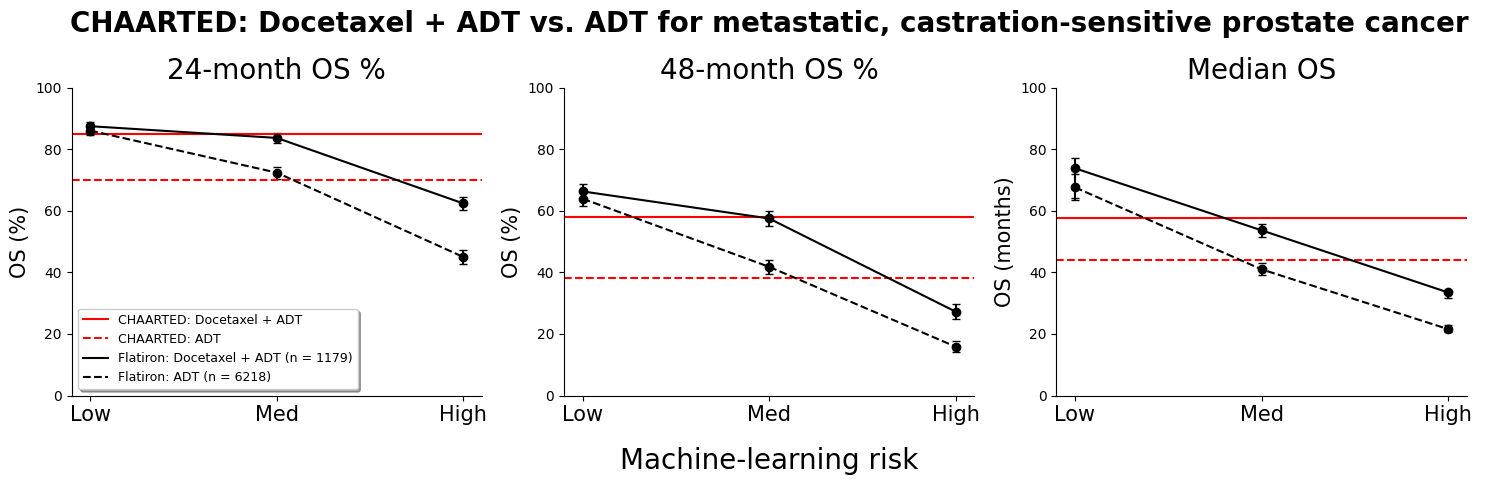

In [117]:
ml_risk = ['Low', 'Med',  'High']

fig = plt.figure(figsize=(18, 4))

# 24 month OS plot
plt.subplot(1, 3, 1)
plt.errorbar(ml_risk, dotx_chaarted_24_os, yerr = y_error_dotx_chaarted_24, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 85, color = 'red', linestyle = 'solid')

eb1 = plt.errorbar(ml_risk, adt_chaarted_24_os, yerr = y_error_adt_chaarted_24, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb1[-1][0].set_linestyle(':')
plt.axhline(y = 70, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 100)
plt.ylabel('OS (%)', size = 15)

plt.title('24-month OS %', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 48 month OS plot
plt.subplot(1, 3, 2)
plt.errorbar(ml_risk, dotx_chaarted_48_os, yerr = y_error_dotx_chaarted_48, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 58, color = 'red', linestyle = 'solid')

eb2 = plt.errorbar(ml_risk, adt_chaarted_48_os, yerr = y_error_adt_chaarted_48, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb2[-1][0].set_linestyle(':')
plt.axhline(y = 38, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 100)
plt.ylabel('OS (%)', size = 15)

plt.title('48-month OS %', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Median OS plot
plt.subplot(1, 3, 3)
plt.errorbar(ml_risk, dotx_chaarted_median_os[0:3], yerr = y_error_dotx_chaarted_mos, marker = 'o', color = 'black', capsize = 3)

plt.axhline(y = 57.6, color = 'red', linestyle = 'solid')

eb3 = plt.errorbar(ml_risk, adt_chaarted_median_os[0:3], yerr = y_error_adt_chaarted_mos, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb3[-1][0].set_linestyle(':')

plt.axhline(y = 44.0, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.ylim(0, 100)
plt.ylabel('OS (months)', size = 15)

plt.title('Median OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Machine-learning risk', labelpad = 20, size = 20)
plt.title('CHAARTED: Docetaxel + ADT vs. ADT for metastatic, castration-sensitive prostate cancer', pad = 40, size = 20, weight = 'bold', loc = 'center')

legend_elements = [Line2D([0], [0], color = 'red', linestyle = 'solid', label = 'CHAARTED: Docetaxel + ADT'),
                   Line2D([0], [0], color = 'red', linestyle = '--', label = 'CHAARTED: ADT'),
                   Line2D([0], [0], color = 'black', linestyle = 'solid', label = 'Flatiron: Docetaxel + ADT (n = {})'.format(chaarted.query('adt_dotx == 1').shape[0])),
                   Line2D([0], [0], color = 'black', linestyle = '--', label = 'Flatiron: ADT (n = {})'.format(chaarted.query('adt_dotx == 0').shape[0]))]

plt.legend(handles = legend_elements, fancybox = True, shadow = True, loc = 'lower left', prop = {'size': 9})

#plt.savefig('chaarted_summary_rc.png', bbox_inches = 'tight')

plt.show()

### LATITUDE : abiraterone vs. ADT in metastatic, castration-sensitive prostate cancer  

**INCLUSION**
* Untreated metastatic prostate cancer, except up to 3 months of ADT 
* Castration-sensitive
* Received ADT or abiraterone plus ADT

#### ADT

In [118]:
df_full = pd.read_csv('df_risk_crude.csv', dtype = {'death_status': bool})
df_full.index.nunique()

18927

In [119]:
adt = pd.read_csv('Enhanced_MetPC_ADT.csv')

In [120]:
adt = (
    adt[adt['PatientID'].isin(df_full['PatientID'])]
    .query('TreatmentSetting == "Advanced"')
)

In [121]:
row_ID(adt)

(17863, 17863)

In [122]:
adt.loc[:, 'StartDate'] = pd.to_datetime(adt['StartDate'])

In [123]:
adt = adt.rename(columns = {'StartDate': 'StartDate_adt'})

In [124]:
df_full = pd.merge(df_full, adt[['PatientID', 'StartDate_adt']], on = 'PatientID', how = 'outer')

In [125]:
row_ID(df_full)

(18927, 18927)

In [126]:
enhanced_met = pd.read_csv('Enhanced_MetProstate.csv')

In [127]:
enhanced_met = enhanced_met[enhanced_met['PatientID'].isin(df_full['PatientID'])]

In [128]:
enhanced_met.loc[:, 'MetDiagnosisDate'] = pd.to_datetime(enhanced_met['MetDiagnosisDate'])

In [129]:
enhanced_met.loc[:, 'CRPCDate'] = pd.to_datetime(enhanced_met['CRPCDate'])

In [130]:
df_full = pd.merge(df_full, enhanced_met[['PatientID', 'MetDiagnosisDate', 'CRPCDate']], on = 'PatientID')

In [131]:
row_ID(df_full)

(18927, 18927)

In [132]:
# Find all that start ADT within -120 to +90 days of metastatic diagnosis 
latitude_adt = (
    df_full
    .assign(adt_diff = (df_full['StartDate_adt'] - df_full['MetDiagnosisDate']).dt.days)
    .query('adt_diff >= -120 and adt_diff <= 90')
)

In [133]:
# Find all that have missing CPRC date or date is >90 after metastatic diagnosis 
latitude_adt = (
    latitude_adt
    .assign(crpc_diff = (chaarted_adt['CRPCDate'] - chaarted_adt['MetDiagnosisDate']).dt.days)
    .query('crpc_diff > 90 or CRPCDate.isna()', engine = 'python')
)

In [134]:
row_ID(latitude_adt)

(9015, 9015)

In [135]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [136]:
zero = (
    line_therapy.query('LineNumber == 0')
    .PatientID
)

In [137]:
# Exclude patients with missing treatment information (ie, LineNumber == 0)
latitude_adt = latitude_adt[~latitude_adt.PatientID.isin(zero)]

In [138]:
row_ID(latitude_adt)

(9015, 9015)

In [139]:
line_therapy = line_therapy.query('LineSetting != "nmCRPC"')

In [140]:
# List of FDA approved drugs for mPC as of July 2023. Clinical study drug is also included. 
fda_yes = [
    'Abiraterone',
    'Apalutamide',
    'Cabazitaxel',
    'Carboplatin',
    'Cisplatin',
    'Darolutamide',
    'Docetaxel',
    'Enzalutamide',
    'Mitoxantrone',
    'Olaparib',
    'Oxaliplatin',
    'Paclitaxel',
    'Pembrolizumab',
    'Radium-223',
    'Rucaparib',
    'Sipuleucel-T',
    'Clinical Study Drug'
]

In [141]:
line_therapy = line_therapy[line_therapy['LineName'].str.contains('|'.join(fda_yes))]

In [142]:
line_therapy = (
    line_therapy
    .sort_values(by = ['PatientID', 'StartDate'], ascending = [True, True])
)

In [143]:
line_therapy['line_number'] = (
    line_therapy.groupby('PatientID')['LineNumber'].cumcount()+1
)

In [144]:
# First line therapy is in castrate-resistant setting 
fl_crpc = (
    line_therapy[line_therapy.PatientID.isin(latitude_adt.PatientID)]
    .query('line_number == 1 & LineSetting == "mCRPC"')
    .PatientID
)

In [145]:
# Never received therapy other than ADT
notrt_adt = (
    latitude_adt[~latitude_adt.PatientID.isin(line_therapy.PatientID)]
    .PatientID
)

In [146]:
adt_IDs = np.concatenate((fl_crpc, notrt_adt))

In [147]:
len(adt_IDs)

6218

In [148]:
latitude_adt = latitude_adt[latitude_adt.PatientID.isin(adt_IDs)]

In [149]:
latitude_adt.loc[:,'adt_abi'] = 0

In [150]:
row_ID(latitude_adt)

(6218, 6218)

In [151]:
latitude_adt.sample(3)

,PatientID,Gender,race,ethnicity,age,p_type,NStage,MStage,Histology,GleasonScore,...,other_met,prim_treatment,early_adt,risk_score,StartDate_adt,MetDiagnosisDate,CRPCDate,adt_diff,crpc_diff,adt_abi
9762,F28ED193E444B,M,white,unknown,78,COMMUNITY,Unknown / Not documented,Unknown / Not documented,Adenocarcinoma,Unknown / Not documented,...,0.0,prostatectomy,0.0,-0.328903,2015-07-29,2015-07-10,2017-04-19,19.0,649.0,0
16281,F81C18DE1EC06,M,white,unknown,83,COMMUNITY,NX,M1,Adenocarcinoma,Unknown / Not documented,...,0.0,unknown,0.0,0.759179,2020-09-09,2020-08-07,NaT,33.0,NaN,0
18289,FA3E5B7437A50,M,white,unknown,78,COMMUNITY,Unknown / Not documented,M1,Adenocarcinoma,9,...,0.0,unknown,0.0,0.011443,2015-02-17,2015-02-03,2016-03-18,14.0,409.0,0


#### Treatment arm: Abiraterone + ADT

In [152]:
# Find those that start ADT within -90 to 90 days of metastaic diagnosis 
latitude_abi = (
    df_full
    .assign(adt_diff = (df_full['StartDate_adt'] - df_full['MetDiagnosisDate']).dt.days)
    .query('adt_diff >= -90 and adt_diff <= 90')
)

In [153]:
# Find all that have missing CPRC date or date is >30 days metastatic diagnosis 
latitude_abi = (
    latitude_abi
    .assign(crpc_diff = (latitude_abi['CRPCDate'] - latitude_abi['MetDiagnosisDate']).dt.days)
    .query('crpc_diff > 90 or CRPCDate.isna()', engine = 'python')
)

In [154]:
row_ID(latitude_abi)

(10397, 10397)

In [155]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [156]:
# Find start time of first line of mHSPC therapy. 
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(latitude_abi['PatientID'])]
    .query('LineSetting == "mHSPC"')
    .sort_values(by = ['PatientID', 'StartDate'], ascending = [True, True])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .rename(columns = {'StartDate': 'StartDate_abi'})
)

In [157]:
row_ID(line_therapy_fl)

(4022, 4022)

In [158]:
line_therapy_fl.loc[:, 'StartDate_abi'] = pd.to_datetime(line_therapy_fl['StartDate_abi'])

In [159]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('Abiraterone')].LineName.value_counts().head(10)

Abiraterone                             1165
Abiraterone,Docetaxel                     27
Abiraterone,Enzalutamide                   8
Abiraterone,Clinical Study Drug            4
Abiraterone,Apalutamide                    4
Abiraterone,Apalutamide,Enzalutamide       1
Abiraterone,Capecitabine                   1
Abiraterone,Medroxyprogesterone            1
Abiraterone,Fluorouracil                   1
Abiraterone,Tamoxifen                      1
Name: LineName, dtype: int64

In [160]:
line_abi = line_therapy_fl.query('LineName == "Abiraterone"')

In [161]:
row_ID(line_abi)

(1165, 1165)

In [162]:
latitude_abi = pd.merge(latitude_abi, line_abi[['PatientID', 'StartDate_abi']], on = 'PatientID', how = 'inner')

In [163]:
row_ID(latitude_abi)

(1165, 1165)

In [164]:
# Find all patients that start abiraterone within 90 days of ADT start
latitude_abi = (
    latitude_abi
    .assign(abi_diff = (latitude_abi['StartDate_abi'] - latitude_abi['StartDate_adt']).dt.days)
    .query('abi_diff >= -90 and abi_diff <= 90')
)

In [165]:
row_ID(latitude_abi)

(876, 876)

In [166]:
latitude_abi.sample(3)

,PatientID,Gender,race,ethnicity,age,p_type,NStage,MStage,Histology,GleasonScore,...,prim_treatment,early_adt,risk_score,StartDate_adt,MetDiagnosisDate,CRPCDate,adt_diff,crpc_diff,StartDate_abi,abi_diff
590,F105963E5EBF8,M,white,unknown,78,COMMUNITY,Unknown / Not documented,M0,Adenocarcinoma,Less than or equal to 6,...,radiation,0.0,-0.031527,2022-05-10,2022-04-06,NaT,34.0,NaN,2022-04-12,-28
739,FDC0475A051A9,M,white,unknown,75,COMMUNITY,N0,M0,Adenocarcinoma,9,...,prostatectomy,0.0,-1.334960,2018-02-05,2018-01-23,NaT,13.0,NaN,2018-02-07,2
706,FBE12C247909D,M,unknown,hispanic_latino,58,COMMUNITY,N1,M1b,Adenocarcinoma,9,...,unknown,0.0,-1.243935,2020-10-09,2020-09-09,NaT,30.0,NaN,2020-11-12,34


In [167]:
latitude_abi.loc[:,'adt_abi'] = 1

In [168]:
latitude = pd.concat([latitude_adt, latitude_abi], ignore_index = True)

In [169]:
row_ID(latitude)

(7094, 7094)

In [170]:
latitude.adt_abi.value_counts(dropna = False)

0    6218
1     876
Name: adt_abi, dtype: int64

#### Time from ADT treatment to death or censor 

In [171]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [172]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [173]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [174]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [175]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
row_ID(mortality)

(18927, 18927)

In [176]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [177]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [178]:
len(mortality)

18927

In [179]:
latitude = pd.merge(latitude, mortality, on = 'PatientID')

In [180]:
row_ID(latitude)

(7094, 7094)

In [181]:
conditions = [
    (latitude['death_status'] == 1),
    (latitude['death_status'] == 0)]

choices = [
    (latitude['death_date'] - latitude['StartDate_adt']).dt.days,
    (latitude['last_activity'] - latitude['StartDate_adt']).dt.days]

latitude.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

latitude = latitude.query('timerisk_treatment >= 0')

#### Patient count 

In [182]:
low_cutoff_latitude = latitude.risk_score.quantile(1/3)

In [183]:
high_cutoff_latitude = latitude.risk_score.quantile(2/3)

In [184]:
print('Abiraterone + ADT:',  latitude.query('adt_abi == 1').shape[0])
print('High risk:', latitude.query('adt_abi == 1').query('risk_score >= @high_cutoff_latitude').shape[0])
print('Med risk:', latitude.query('adt_abi == 1').query('risk_score < @high_cutoff_latitude and risk_score > @low_cutoff_latitude').shape[0])
print('Low risk:', latitude.query('adt_abi == 1').query('risk_score <= @low_cutoff_latitude').shape[0])

Abiraterone + ADT: 876
High risk: 275
Med risk: 258
Low risk: 343


In [185]:
print('ADT:',  latitude.query('adt_abi == 0').shape[0])
print('High risk:', latitude.query('adt_abi == 0').query('risk_score >= @high_cutoff_latitude').shape[0])
print('Med risk:', latitude.query('adt_abi == 0').query('risk_score < @high_cutoff_latitude and risk_score > @low_cutoff_latitude').shape[0])
print('Low risk:', latitude.query('adt_abi == 0').query('risk_score <= @low_cutoff_latitude').shape[0])

ADT: 6218
High risk: 2090
Med risk: 2106
Low risk: 2022


In [186]:
risk_cutoff_prostate.loc['latitude'] = [low_cutoff_latitude, high_cutoff_latitude]

In [187]:
risk_cutoff_prostate

,low,high
chaarted,-0.445904,0.087889
latitude,-0.446882,0.103503


In [188]:
risk_cutoff_prostate.to_csv('risk_cutoff_prostate.csv', index = True)

#### OS curves without confounder adjustment 

In [189]:
latitude = latitude.set_index('PatientID')

In [190]:
latitude_low_abi = (
    latitude
    .query('adt_abi == 1')
    .query('risk_score <= @low_cutoff_latitude')
    .index)

latitude_low_adt = (
    latitude
    .query('adt_abi == 0')
    .query('risk_score <= @low_cutoff_latitude')
    .index)

latitude_med_abi = (
    latitude
    .query('adt_abi == 1')
    .query('risk_score < @high_cutoff_latitude and risk_score > @low_cutoff_latitude')
    .index)

latitude_med_adt = (
    latitude
    .query('adt_abi == 0')
    .query('risk_score < @high_cutoff_latitude and risk_score > @low_cutoff_latitude')
    .index)

latitude_high_abi = (
    latitude
    .query('adt_abi == 1')
    .query('risk_score >= @high_cutoff_latitude')
    .index)

latitude_high_adt = (
    latitude
    .query('adt_abi == 0')
    .query('risk_score >= @high_cutoff_latitude')
    .index)

latitude_all_abi = (
    latitude
    .query('adt_abi == 1')
    .index)

latitude_all_adt = (
    latitude
    .query('adt_abi == 0')
    .index)

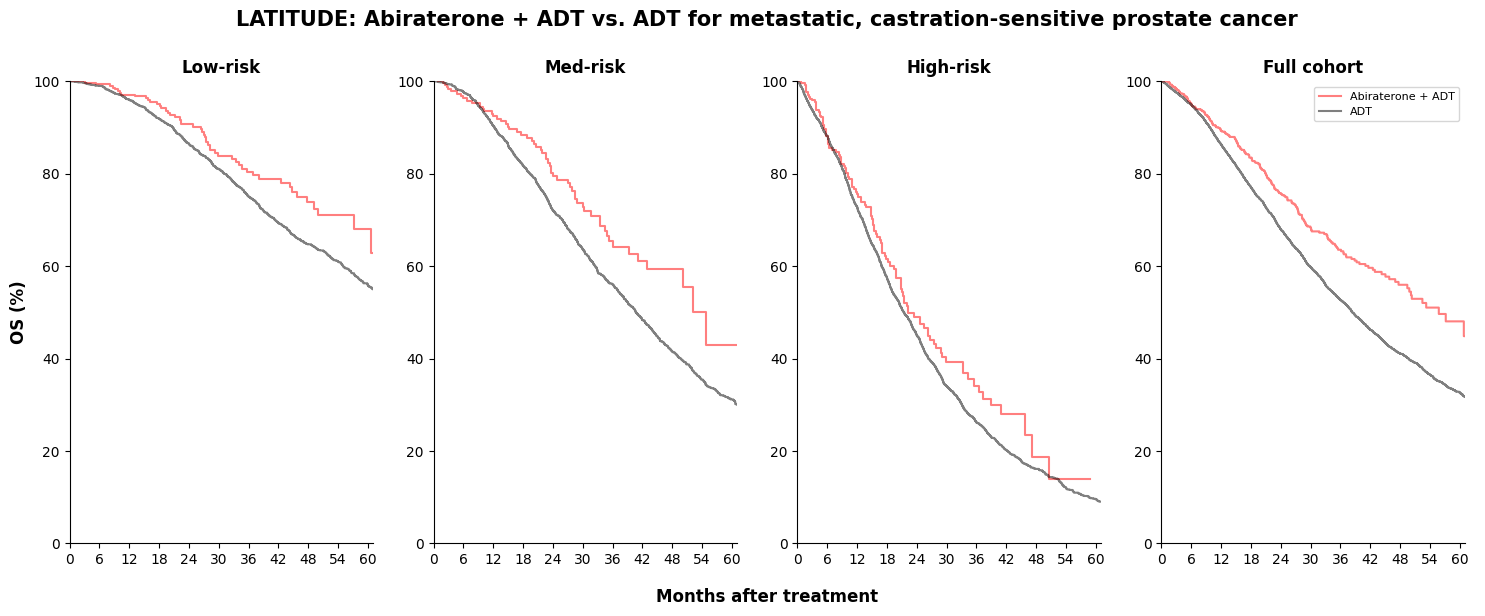

In [191]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

time_low_abi, survival_prob_low_abi = kaplan_meier_estimator(np.array(latitude.loc[latitude_low_abi]['death_status']),
                                                             np.array(latitude.loc[latitude_low_abi]['timerisk_treatment']))

time_low_adt_l, survival_prob_low_adt_l = kaplan_meier_estimator(np.array(latitude.loc[latitude_low_adt]['death_status']),
                                                                 np.array(latitude.loc[latitude_low_adt]['timerisk_treatment']))

plt.step(time_low_abi/30, survival_prob_low_abi*100, color = 'red', alpha = 0.5)
plt.step(time_low_adt_l/30, survival_prob_low_adt_l*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('OS (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for medium risk group. 
plt.subplot(1, 4, 2)

time_med_abi, survival_prob_med_abi = kaplan_meier_estimator(np.array(latitude.loc[latitude_med_abi]['death_status']),
                                                             np.array(latitude.loc[latitude_med_abi]['timerisk_treatment']))

time_med_adt_l, survival_prob_med_adt_l = kaplan_meier_estimator(np.array(latitude.loc[latitude_med_adt]['death_status']),
                                                                 np.array(latitude.loc[latitude_med_adt]['timerisk_treatment']))

plt.step(time_med_abi/30, survival_prob_med_abi*100, color = 'red', alpha = 0.5)
plt.step(time_med_adt_l/30, survival_prob_med_adt_l*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

time_high_abi, survival_prob_high_abi = kaplan_meier_estimator(np.array(latitude.loc[latitude_high_abi]['death_status']),
                                                               np.array(latitude.loc[latitude_high_abi]['timerisk_treatment']))

time_high_adt_l, survival_prob_high_adt_l = kaplan_meier_estimator(np.array(latitude.loc[latitude_high_adt]['death_status']),
                                                                   np.array(latitude.loc[latitude_high_adt]['timerisk_treatment']))

plt.step(time_high_abi/30, survival_prob_high_abi*100, color = 'red', alpha = 0.5)
plt.step(time_high_adt_l/30, survival_prob_high_adt_l*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatmetn for all 
plt.subplot(1, 4, 4)

time_all_abi, survival_prob_all_abi = kaplan_meier_estimator(np.array(latitude.loc[latitude_all_abi]['death_status']),
                                                             np.array(latitude.loc[latitude_all_abi]['timerisk_treatment']))

time_all_adt_l, survival_prob_all_adt_l = kaplan_meier_estimator(np.array(latitude.loc[latitude_all_adt]['death_status']),
                                                                 np.array(latitude.loc[latitude_all_adt]['timerisk_treatment']))

plt.step(time_all_abi/30, survival_prob_all_abi*100, color = 'red', alpha = 0.5, label = 'Abiraterone + ADT')
plt.step(time_all_adt_l/30, survival_prob_all_adt_l*100, color = 'black', alpha = 0.5, label = 'ADT')

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 8})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('LATITUDE: Abiraterone + ADT vs. ADT for metastatic, castration-sensitive prostate cancer', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Survival with confounder adjustment via IPTW

In [192]:
latitude_iptw = latitude.filter(items = ['death_status',
                                         'timerisk_treatment',
                                         'adt_abi',
                                         'age',
                                         'race',
                                         'p_type',
                                         'met_year',
                                         'commercial',
                                         'medicare',
                                         'medicaid',
                                         'risk_score'])

In [193]:
latitude_iptw.dtypes

death_status             bool
timerisk_treatment    float64
adt_abi                 int64
age                     int64
race                   object
p_type                 object
met_year                int64
commercial            float64
medicare              float64
medicaid              float64
risk_score            float64
dtype: object

In [194]:
to_be_categorical = list(latitude_iptw.select_dtypes(include = ['object']).columns)

In [195]:
to_be_categorical

['race', 'p_type']

In [196]:
to_be_categorical.append('met_year')

In [197]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    latitude_iptw[x] = latitude_iptw[x].astype('category')

In [198]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [199]:
# List of categorical features.
categorical_features = list(latitude_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [200]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [201]:
latitude_iptw_low = (
    latitude_iptw
    .query('risk_score <= @low_cutoff_latitude')
    .drop(columns = ['risk_score']))

latitude_iptw_med = (
    latitude_iptw
    .query('risk_score < @high_cutoff_latitude and risk_score > @low_cutoff_latitude')
    .drop(columns = ['risk_score']))

latitude_iptw_high = (
    latitude_iptw
    .query('risk_score >= @high_cutoff_latitude')
    .drop(columns = ['risk_score']))

In [202]:
latitude_low_x = preprocessor.fit_transform(latitude_iptw_low.filter(items = ['age',
                                                                              'race',
                                                                              'p_type',
                                                                              'met_year',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid']))

latitude_med_x = preprocessor.fit_transform(latitude_iptw_med.filter(items = ['age',
                                                                              'race',
                                                                              'p_type',
                                                                              'met_year',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid']))

latitude_high_x = preprocessor.fit_transform(latitude_iptw_high.filter(items = ['age',
                                                                                'race',
                                                                                'p_type',
                                                                                'met_year',
                                                                                'commercial',
                                                                                'medicare',
                                                                                'medicaid']))

In [203]:
lr_latitude_low = LogisticRegression(max_iter = 1000)
lr_latitude_low.fit(latitude_low_x, latitude_iptw_low['adt_abi'])

LogisticRegression(max_iter=1000)

In [204]:
lr_latitude_med = LogisticRegression(max_iter = 1000)
lr_latitude_med.fit(latitude_med_x, latitude_iptw_med['adt_abi'])

LogisticRegression(max_iter=1000)

In [205]:
lr_latitude_high = LogisticRegression(max_iter = 1000)
lr_latitude_high.fit(latitude_high_x, latitude_iptw_high['adt_abi'])

LogisticRegression(max_iter=1000)

In [206]:
pred_low = lr_latitude_low.predict_proba(latitude_low_x)
pred_med = lr_latitude_med.predict_proba(latitude_med_x)
pred_high = lr_latitude_high.predict_proba(latitude_high_x)

In [207]:
latitude_iptw_low['ps'] = pred_low[:, 1]
latitude_iptw_med['ps'] = pred_med[:, 1]
latitude_iptw_high['ps'] = pred_high[:, 1]

In [208]:
latitude_iptw_low['weight'] = (
    np.where(latitude_iptw_low['adt_abi'] == 1, 1/latitude_iptw_low['ps'], 1/(1 - latitude_iptw_low['ps'])))

latitude_iptw_med['weight'] = (
    np.where(latitude_iptw_med['adt_abi'] == 1, 1/latitude_iptw_med['ps'], 1/(1 - latitude_iptw_med['ps'])))

latitude_iptw_high['weight'] = (
    np.where(latitude_iptw_high['adt_abi'] == 1, 1/latitude_iptw_high['ps'], 1/(1 - latitude_iptw_high['ps'])))

In [209]:
latitude_iptw_all = pd.concat([latitude_iptw_low, latitude_iptw_med, latitude_iptw_high])

In [210]:
# Low KM curves
kmf_low_abi_latitude_iptw = KaplanMeierFitter()
kmf_low_adt_latitude_iptw = KaplanMeierFitter()

kmf_low_abi_latitude_iptw.fit(
    latitude_iptw_low.query('adt_abi == 1').timerisk_treatment/30,
    latitude_iptw_low.query('adt_abi == 1').death_status,
    weights = latitude_iptw_low.query('adt_abi == 1')['weight'])

kmf_low_adt_latitude_iptw.fit(
    latitude_iptw_low.query('adt_abi == 0').timerisk_treatment/30,
    latitude_iptw_low.query('adt_abi == 0').death_status,
    weights = latitude_iptw_low.query('adt_abi == 0')['weight'])

# Med KM curves
kmf_med_abi_latitude_iptw = KaplanMeierFitter()
kmf_med_adt_latitude_iptw = KaplanMeierFitter()

kmf_med_abi_latitude_iptw.fit(
    latitude_iptw_med.query('adt_abi == 1').timerisk_treatment/30,
    latitude_iptw_med.query('adt_abi == 1').death_status,
    weights = latitude_iptw_med.query('adt_abi == 1')['weight'])

kmf_med_adt_latitude_iptw.fit(
    latitude_iptw_med.query('adt_abi == 0').timerisk_treatment/30,
    latitude_iptw_med.query('adt_abi == 0').death_status,
    weights = latitude_iptw_med.query('adt_abi == 0')['weight'])

# High KM curves 
kmf_high_abi_latitude_iptw = KaplanMeierFitter()
kmf_high_adt_latitude_iptw = KaplanMeierFitter()

kmf_high_abi_latitude_iptw.fit(
    latitude_iptw_high.query('adt_abi == 1').timerisk_treatment/30,
    latitude_iptw_high.query('adt_abi == 1').death_status,
    weights = latitude_iptw_high.query('adt_abi == 1')['weight'])

kmf_high_adt_latitude_iptw.fit(
    latitude_iptw_high.query('adt_abi == 0').timerisk_treatment/30,
    latitude_iptw_high.query('adt_abi == 0').death_status,
    weights = latitude_iptw_high.query('adt_abi == 0')['weight'])

# All KM curves 
kmf_all_abi_latitude_iptw = KaplanMeierFitter()
kmf_all_adt_latitude_iptw = KaplanMeierFitter()

kmf_all_abi_latitude_iptw.fit(
    latitude_iptw_all.query('adt_abi == 1').timerisk_treatment/30,
    latitude_iptw_all.query('adt_abi == 1').death_status,
    weights = latitude_iptw_all.query('adt_abi == 1')['weight'])

kmf_all_adt_latitude_iptw.fit(
    latitude_iptw_all.query('adt_abi == 0').timerisk_treatment/30,
    latitude_iptw_all.query('adt_abi == 0').death_status,
    weights = latitude_iptw_all.query('adt_abi == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7085.76 total observations, 3314.44 right-censored observations>

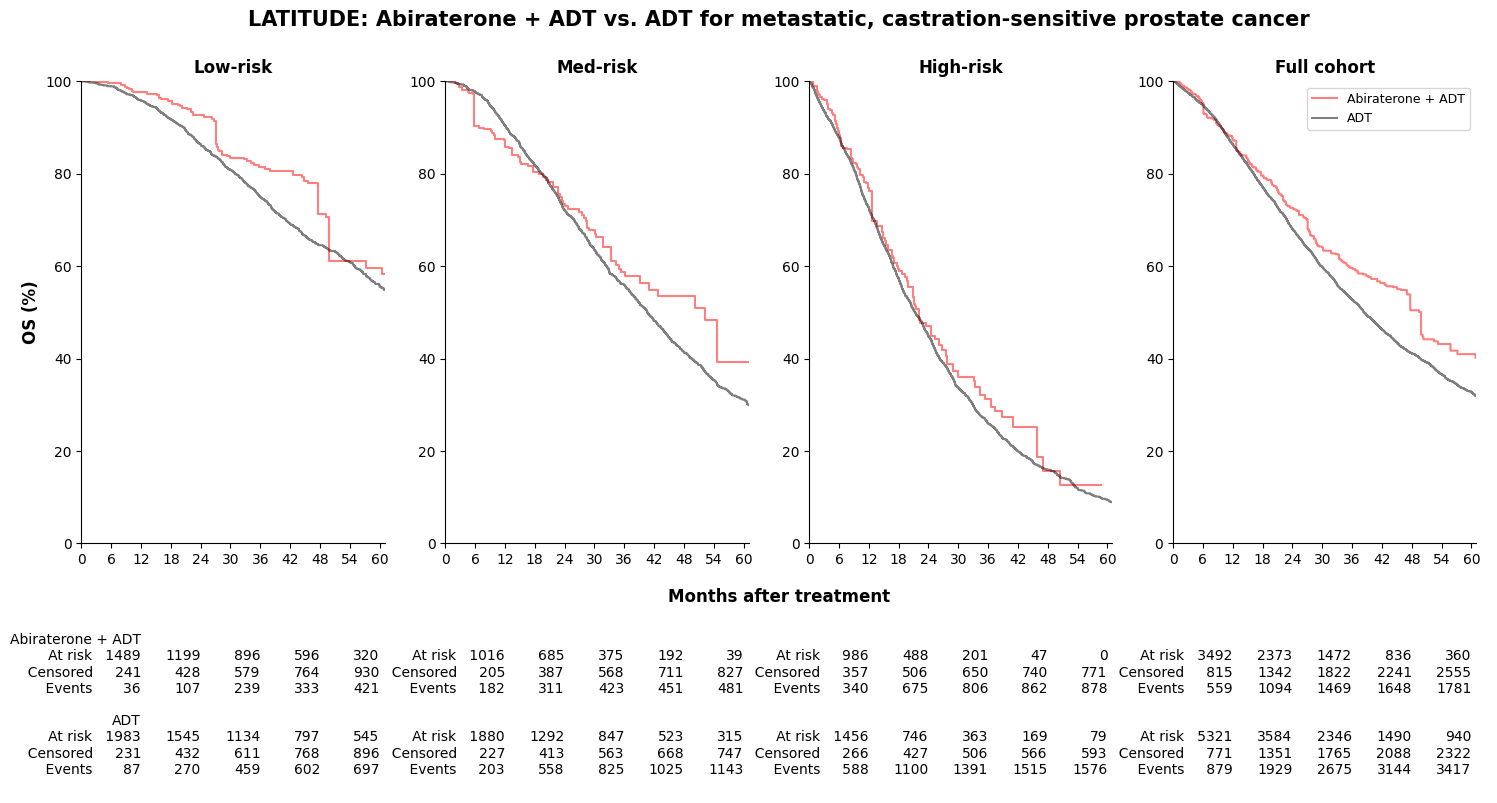

In [211]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_abi_latitude_iptw.timeline, kmf_low_abi_latitude_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_low_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_low_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_low_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_low_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_low_pfulv_paloma3_iptw.timeline, np.array(kmf_low_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_low_adt_latitude_iptw.timeline, kmf_low_adt_latitude_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_low_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_low_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_low_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_low_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_low_fulv_paloma3_iptw.timeline, np.array(kmf_low_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('OS (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_low_abi_latitude_iptw, kmf_low_adt_latitude_iptw, ypos = -0.8, xticks = np.arange(12, 61, 12), labels = ['Abiraterone + ADT', 'ADT'])

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_abi_latitude_iptw.timeline, kmf_med_abi_latitude_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_med_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_med_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_med_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_med_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_med_pfulv_paloma3_iptw.timeline, np.array(kmf_med_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_med_adt_latitude_iptw.timeline, kmf_med_adt_latitude_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_med_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_med_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_med_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_med_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_med_fulv_paloma3_iptw.timeline, np.array(kmf_med_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_med_abi_latitude_iptw, kmf_med_adt_latitude_iptw, ypos = -0.8, xticks = np.arange(12, 61, 12), labels = [' ', ' '])

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_abi_latitude_iptw.timeline, kmf_high_abi_latitude_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_high_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_high_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_high_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_high_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_high_pfulv_paloma3_iptw.timeline, np.array(kmf_high_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_high_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_high_adt_latitude_iptw.timeline, kmf_high_adt_latitude_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_high_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_high_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_high_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_high_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_high_fulv_paloma3_iptw.timeline, np.array(kmf_high_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_high_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_high_abi_latitude_iptw, kmf_high_adt_latitude_iptw, ypos = -0.8, xticks = np.arange(12, 61, 12), labels = [' ', ' '])

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_abi_latitude_iptw.timeline, kmf_all_abi_latitude_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Abiraterone + ADT')
#plt.step(kmf_all_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_all_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_all_pfulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_all_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_all_pfulv_paloma3_iptw.timeline, np.array(kmf_all_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_pfulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_all_adt_latitude_iptw.timeline, kmf_all_adt_latitude_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'ADT')
#plt.step(kmf_all_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_all_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_all_fulv_paloma3_iptw.confidence_interval_.index, np.array(kmf_all_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_all_fulv_paloma3_iptw.timeline, np.array(kmf_all_fulv_paloma3_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_fulv_paloma3_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 9})

add_at_risk_counts(kmf_all_abi_latitude_iptw, kmf_all_adt_latitude_iptw, ypos = -0.8, xticks = np.arange(12, 61, 12), labels = [' ', ' '])

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('LATITUDE: Abiraterone + ADT vs. ADT for metastatic, castration-sensitive prostate cancer', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Summary result plot 

In [212]:
abi_latitude_24_os = psurv_t(kmf_low_abi_latitude_iptw,
                             kmf_med_abi_latitude_iptw,
                             kmf_high_abi_latitude_iptw,
                             24)

adt_latitude_24_os = psurv_t(kmf_low_adt_latitude_iptw,
                             kmf_med_adt_latitude_iptw,
                             kmf_high_adt_latitude_iptw,
                             24)

abi_latitude_48_os = psurv_t(kmf_low_abi_latitude_iptw,
                             kmf_med_abi_latitude_iptw,
                             kmf_high_abi_latitude_iptw,
                             48)

adt_latitude_48_os = psurv_t(kmf_low_adt_latitude_iptw,
                             kmf_med_adt_latitude_iptw,
                             kmf_high_adt_latitude_iptw,
                             48)

abi_latitude_median_os = mos(kmf_low_abi_latitude_iptw,
                             kmf_med_abi_latitude_iptw,
                             kmf_high_abi_latitude_iptw,
                             kmf_all_abi_latitude_iptw)

adt_latitude_median_os = mos(kmf_low_adt_latitude_iptw,
                             kmf_med_adt_latitude_iptw,
                             kmf_high_adt_latitude_iptw,
                             kmf_all_adt_latitude_iptw)

In [213]:
print('All, abiraterone: ',truncate(abi_latitude_median_os[3], 3))
print('All, ADT: ',truncate(adt_latitude_median_os[3], 3))

print('Low, abiraterone: ',abi_latitude_median_os[0])
print('Low, ADT: ',truncate(adt_latitude_median_os[0], 3))

print('Med, abiraterone: ',truncate(abi_latitude_median_os[1], 3))
print('Med, ADT: ',truncate(adt_latitude_median_os[1], 3))

print('High, abiraterone: ',truncate(abi_latitude_median_os[2], 3))
print('High, ADT: ',truncate(adt_latitude_median_os[2], 3))

All, abiraterone:  49.966
All, ADT:  38.466
Low, abiraterone:  inf
Low, ADT:  68.433
Med, abiraterone:  52.566
Med, ADT:  40.666
High, abiraterone:  22.133
High, ADT:  21.366


In [214]:
abi_latitude_low_24_ci = psurv_ci(kmf_low_abi_latitude_iptw, 24)
abi_latitude_med_24_ci = psurv_ci(kmf_med_abi_latitude_iptw, 24)
abi_latitude_high_24_ci = psurv_ci(kmf_high_abi_latitude_iptw, 24)

y_error_abi_latitude_24 = y_error(abi_latitude_low_24_ci,
                                  abi_latitude_med_24_ci,
                                  abi_latitude_high_24_ci,
                                  abi_latitude_24_os)

In [215]:
adt_latitude_low_24_ci = psurv_ci(kmf_low_adt_latitude_iptw, 24)
adt_latitude_med_24_ci = psurv_ci(kmf_med_adt_latitude_iptw, 24)
adt_latitude_high_24_ci = psurv_ci(kmf_high_adt_latitude_iptw, 24)

y_error_adt_latitude_24 = y_error(adt_latitude_low_24_ci,
                                  adt_latitude_med_24_ci,
                                  adt_latitude_high_24_ci,
                                  adt_latitude_24_os)

In [216]:
abi_latitude_low_48_ci = psurv_ci(kmf_low_abi_latitude_iptw, 48)
abi_latitude_med_48_ci = psurv_ci(kmf_med_abi_latitude_iptw, 48)
abi_latitude_high_48_ci = psurv_ci(kmf_high_abi_latitude_iptw, 48)

y_error_abi_latitude_48 = y_error(abi_latitude_low_48_ci,
                                  abi_latitude_med_48_ci,
                                  abi_latitude_high_48_ci,
                                  abi_latitude_48_os)

In [217]:
adt_latitude_low_48_ci = psurv_ci(kmf_low_adt_latitude_iptw, 48)
adt_latitude_med_48_ci = psurv_ci(kmf_med_adt_latitude_iptw, 48)
adt_latitude_high_48_ci = psurv_ci(kmf_high_adt_latitude_iptw, 48)

y_error_adt_latitude_48 = y_error(adt_latitude_low_48_ci,
                                  adt_latitude_med_48_ci,
                                  adt_latitude_high_48_ci,
                                  adt_latitude_48_os)

In [218]:
abi_latitude_low_mos_ci = mos_ci(kmf_low_abi_latitude_iptw)
abi_latitude_med_mos_ci = mos_ci(kmf_med_abi_latitude_iptw)
abi_latitude_high_mos_ci = mos_ci(kmf_high_abi_latitude_iptw)

y_error_abi_latitude_mos = y_error(abi_latitude_low_mos_ci,
                                   abi_latitude_med_mos_ci,
                                   abi_latitude_high_mos_ci,
                                   abi_latitude_median_os)

In [219]:
adt_latitude_low_mos_ci = mos_ci(kmf_low_adt_latitude_iptw)
adt_latitude_med_mos_ci = mos_ci(kmf_med_adt_latitude_iptw)
adt_latitude_high_mos_ci = mos_ci(kmf_high_adt_latitude_iptw)

y_error_adt_latitude_mos = y_error(adt_latitude_low_mos_ci,
                                   adt_latitude_med_mos_ci,
                                   adt_latitude_high_mos_ci,
                                   adt_latitude_median_os)

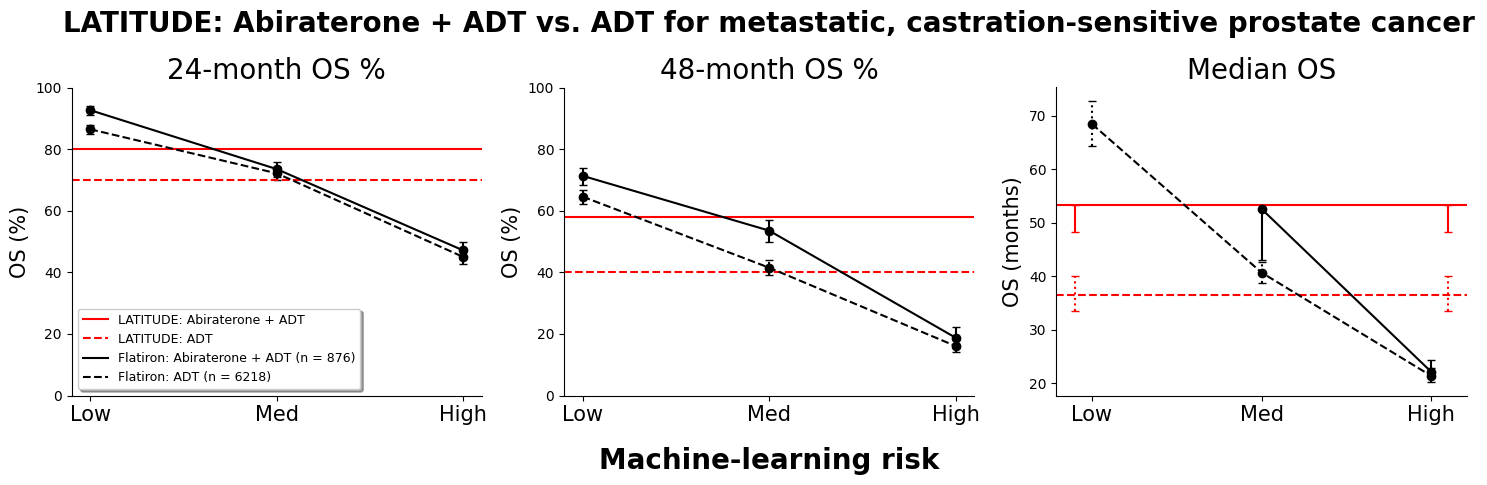

In [220]:
ml_risk = ['Low', 'Med',  'High']

fig = plt.figure(figsize=(18, 4))

# 24 month OS plot
plt.subplot(1, 3, 1)
plt.errorbar(ml_risk, abi_latitude_24_os, yerr = y_error_abi_latitude_24, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 80, color = 'red', linestyle = 'solid')

eb1 = plt.errorbar(ml_risk, adt_latitude_24_os, yerr = y_error_adt_latitude_24, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb1[-1][0].set_linestyle(':')
plt.axhline(y = 70, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 100)
plt.ylabel('OS (%)', size = 15)

plt.title('24-month OS %', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 48 month OS plot
plt.subplot(1, 3, 2)
plt.errorbar(ml_risk, abi_latitude_48_os, yerr = y_error_abi_latitude_48, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 58, color = 'red', linestyle = 'solid')

eb2 = plt.errorbar(ml_risk, adt_latitude_48_os, yerr = y_error_adt_latitude_48, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb2[-1][0].set_linestyle(':')
plt.axhline(y = 40, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 100)
plt.ylabel('OS (%)', size = 15)

plt.title('48-month OS %', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Median OS plot
plt.subplot(1, 3, 3)
plt.errorbar(ml_risk, abi_latitude_median_os[0:3], yerr = y_error_abi_latitude_mos, marker = 'o', color = 'black', capsize = 3)

plt.axhline(y = 53.3, color = 'red', linestyle = 'solid')
x_positions = [-0.1, 2.1]
for x in x_positions:
    plt.errorbar(x, 53.3, yerr=[np.array([53.3-48.2]), np.array([53.3-53.3])], color = 'red', capsize = 3)

eb3 = plt.errorbar(ml_risk, adt_latitude_median_os[0:3], yerr = y_error_adt_latitude_mos, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb3[-1][0].set_linestyle(':')

plt.axhline(y = 36.5, color = 'red', linestyle = '--')
for x, z in zip(x_positions, [4, 5]):
    ebz = plt.errorbar(x, 36.5, yerr=[np.array([36.5-33.5]), np.array([40.0-36.5])], color = 'red', capsize = 3)
    ebz[-1][0].set_linestyle(':')

plt.xticks(fontsize = 15)
plt.ylabel('OS (months)', size = 15)

plt.title('Median OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Machine-learning risk', labelpad = 20, size = 20, weight = 'bold')
plt.title('LATITUDE: Abiraterone + ADT vs. ADT for metastatic, castration-sensitive prostate cancer', pad = 40, size = 20, weight = 'bold', loc = 'center')

legend_elements = [Line2D([0], [0], color = 'red', linestyle = 'solid', label = 'LATITUDE: Abiraterone + ADT'),
                   Line2D([0], [0], color = 'red', linestyle = '--', label = 'LATITUDE: ADT'),
                   Line2D([0], [0], color = 'black', linestyle = 'solid', label = 'Flatiron: Abiraterone + ADT (n = {})'.format(latitude.query('adt_abi == 1').shape[0])),
                   Line2D([0], [0], color = 'black', linestyle = '--', label = 'Flatiron: ADT (n = {})'.format(latitude.query('adt_abi == 0').shape[0]))]

plt.legend(handles = legend_elements, fancybox = True, shadow = True, loc = 'lower left', prop = {'size': 9})

#plt.savefig('latitude_summary_rc.png', bbox_inches = 'tight')

plt.show()